# Loading Dependencies and Data

In [40]:
!pip install pymongo

In [1]:
from pymongo import MongoClient
from google.colab import userdata

connection_string = userdata.get('conn')

client = MongoClient(connection_string)

<ipython-input-1-fd877a0c6b5a>:6: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(connection_string)
/usr/local/lib/python3.11/dist-packages/pymongo/synchronous/mongo_client.py:1737: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  self._resolve_srv()


In [2]:
db = client['vector_storage']
collection = db['code_vectors']

In [3]:
vectors = collection.find()

In [4]:
vectors[0].keys()

dict_keys(['_id', 'code_type', 'vector', 'project_name', 'purpose'])

In [5]:
type(collection)

pymongo.synchronous.collection.Collection

In [6]:
collection.count_documents({})

5307

In [7]:
types = collection.distinct("code_type")
{x:t for t,x in enumerate(types)}

{'cuda': 0,
 'c': 1,
 'cpp': 2,
 'javascript': 3,
 'sql': 4,
 'python': 5,
 'java': 6}

# Preliminary Queries

In [8]:
pipeline = [
    { "$group": { "_id": "$code_type", "count": { "$sum": 1 } } },
    { "$sort": { "count": -1 } }
]

results = list(collection.aggregate(pipeline))
for doc in results: print(doc["_id"], doc["count"])

python 1678
c 770
cpp 693
java 678
cuda 604
sql 509
javascript 375


In [9]:
pipeline = [
    { "$unwind": "$purpose" },
    { "$group": {
        "_id": "$purpose",
        "count": { "$sum": 1 }
    }},
    { "$sort": { "count": -1 } }
]

results = list(collection.aggregate(pipeline))
for doc in results:
    print(doc["_id"], doc["count"])

ai 1917
webserver 1490
llm 888
operating system 667
nn 661
graphics 660
database 508
vision 368
webserver   65


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

vectors = collection.find()
data = pd.DataFrame(vectors)
x_train, x_test, y_train, y_test = train_test_split(
    data['vector'],
    data['code_type'],
    test_size=0.3,
    random_state=97,
    stratify=data['code_type']
)

In [11]:
pipeline = [
    {
        "$group":
        {
            "_id": "$code_type",
            "records": { "$push": "$$ROOT" }
        }
    },
    {
        "$project":
        {
            "_id": 1,
            "records": { "$slice": ["$records", 20] }
        }
    }
]

results = list(collection.aggregate(pipeline))
embeddings = []
types= []
for doc in results:
  for record in doc["records"]:
    types.append(record['code_type'])
    embeddings.append(record['vector'])

# TSNE

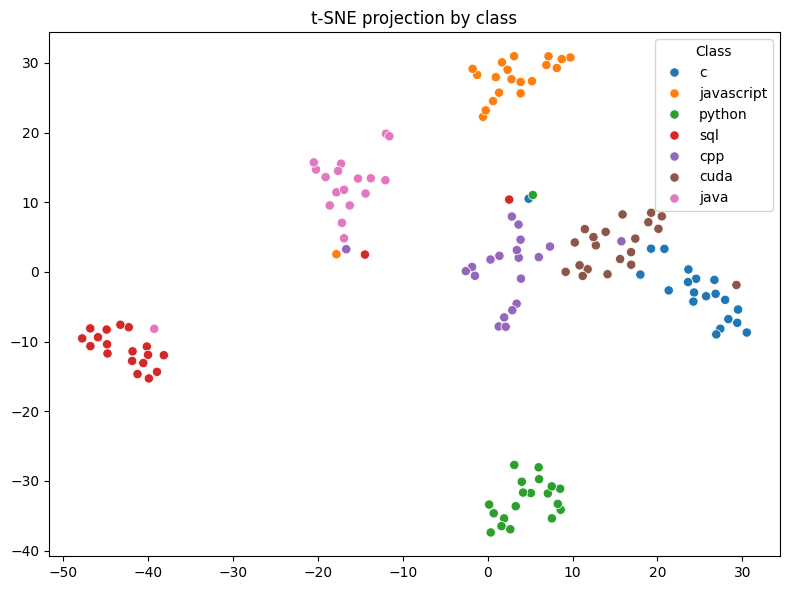

In [12]:
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

X = torch.tensor(embeddings)
y = types

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_embedded = tsne.fit_transform(X)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette='tab10', s=45)
plt.title("t-SNE projection by class")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# Examining Embedding Performance On Code Language Type

In [13]:
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class CodeVectorDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.encoded_classes = {x:t for t,x in enumerate(np.unique(y))}

    def __len__(self):
        return len(self.x) - 1

    def __getitem__(self, idx):
        x = torch.tensor(self.x.iloc[idx])
        y = F.one_hot(torch.tensor(self.encoded_classes[self.y.iloc[idx]]), num_classes=len(self.encoded_classes))
        return x, y

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class VectorClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super(VectorClassifier, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [15]:
train_dataset = CodeVectorDataset(x_train, y_train)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
import torch.optim as optim

model = VectorClassifier(len(np.unique(y_train.values)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_dataset:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 0)
        correct += (predicted == torch.argmax(labels)).sum().item()
        total += 1

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch 1/20 - Loss: 0.9345, Accuracy: 63.68%
Epoch 2/20 - Loss: 0.5212, Accuracy: 80.67%
Epoch 3/20 - Loss: 0.4766, Accuracy: 82.74%
Epoch 4/20 - Loss: 0.4113, Accuracy: 85.49%
Epoch 5/20 - Loss: 0.4114, Accuracy: 85.81%
Epoch 6/20 - Loss: 0.3801, Accuracy: 87.40%
Epoch 7/20 - Loss: 0.3565, Accuracy: 87.86%
Epoch 8/20 - Loss: 0.3459, Accuracy: 87.53%
Epoch 9/20 - Loss: 0.3357, Accuracy: 88.45%
Epoch 10/20 - Loss: 0.3189, Accuracy: 89.63%
Epoch 11/20 - Loss: 0.3501, Accuracy: 87.96%
Epoch 12/20 - Loss: 0.3233, Accuracy: 88.53%
Epoch 13/20 - Loss: 0.3017, Accuracy: 89.34%
Epoch 14/20 - Loss: 0.2926, Accuracy: 90.15%
Epoch 15/20 - Loss: 0.2846, Accuracy: 90.63%
Epoch 16/20 - Loss: 0.3464, Accuracy: 88.83%
Epoch 17/20 - Loss: 0.3034, Accuracy: 89.63%
Epoch 18/20 - Loss: 0.3003, Accuracy: 89.71%
Epoch 19/20 - Loss: 0.2988, Accuracy: 90.20%
Epoch 20/20 - Loss: 0.2845, Accuracy: 90.23%


In [18]:
test_dataset = CodeVectorDataset(x_test, y_test)

In [19]:
model.to(device)
model.eval()
running_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
  for inputs, labels in test_dataset:
      inputs, labels = inputs.to(device), labels.to(device).float()
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 0)
      y_true.append(torch.argmax(labels).item())
      y_pred.append(predicted.item())
      correct += (predicted == torch.argmax(labels)).sum().item()
      total += 1

epoch_acc = correct / total * 100
print(f"Accuracy: {epoch_acc:.2f}%")

Accuracy: 96.67%


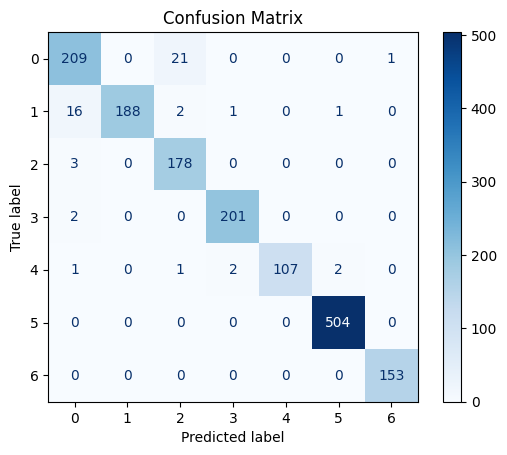

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

<Axes: >

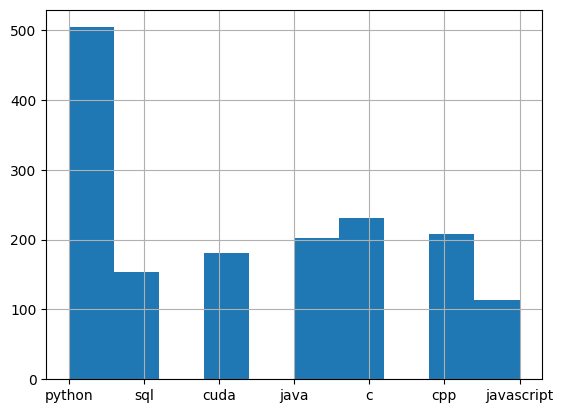

In [20]:
y_test.hist()

<Axes: >

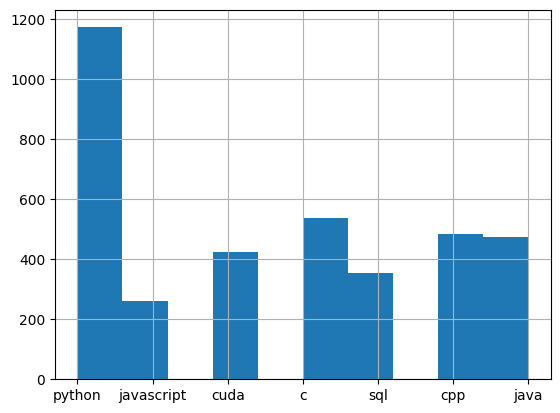

In [22]:
y_train.hist()

In [23]:
test_dataset.encoded_classes

{'c': 0,
 'cpp': 1,
 'cuda': 2,
 'java': 3,
 'javascript': 4,
 'python': 5,
 'sql': 6}

# Examining Embedding Performance On Identifying Purpose

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

multi_purpose_Y = mlb.fit_transform(data.purpose)

In [25]:
mlp_x_train, mlp_x_test, mlp_y_train, mlp_y_test = train_test_split(
    data['vector'],
    multi_purpose_Y,
    test_size=0.3,
    random_state=97,
    stratify=multi_purpose_Y
)

In [26]:
len(mlp_y_train[0])

9

In [27]:
class PurposeVectorDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.reset_index(drop=True)
        self.y = y
        self.encoded_classes = {x:t for t,x in enumerate(np.unique(y))}

    def __len__(self):
        return len(self.x) - 1

    def __getitem__(self, idx):
        x = torch.tensor(self.x.iloc[idx])
        y = torch.tensor(self.y[idx])
        return x, y

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class PurposeModel(nn.Module):
    def __init__(self, classes=9, dropout=0.3):
        super(PurposeModel, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [29]:
train_purposes = PurposeVectorDataset(mlp_x_train, mlp_y_train)

In [39]:
model = PurposeModel(len(mlp_y_train[0]))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(device)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_purposes:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device).float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        result = (preds.cpu().numpy() == labels.cpu().int().numpy()).sum() == 9
        correct += 1 if result else 0
        total += 1
        running_loss += loss.item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch 1/20 - Loss: 0.2566, Accuracy: 38.91%
Epoch 2/20 - Loss: 0.1705, Accuracy: 62.79%
Epoch 3/20 - Loss: 0.1462, Accuracy: 68.85%
Epoch 4/20 - Loss: 0.1307, Accuracy: 72.37%
Epoch 5/20 - Loss: 0.1286, Accuracy: 72.51%
Epoch 6/20 - Loss: 0.1248, Accuracy: 73.10%
Epoch 7/20 - Loss: 0.1387, Accuracy: 72.70%
Epoch 8/20 - Loss: 0.1351, Accuracy: 73.69%
Epoch 9/20 - Loss: 0.1321, Accuracy: 75.15%
Epoch 10/20 - Loss: 0.1391, Accuracy: 70.01%
Epoch 11/20 - Loss: 0.1285, Accuracy: 76.87%
Epoch 12/20 - Loss: 0.1251, Accuracy: 78.30%
Epoch 13/20 - Loss: 0.1322, Accuracy: 74.61%
Epoch 14/20 - Loss: 0.1221, Accuracy: 77.71%
Epoch 15/20 - Loss: 0.1156, Accuracy: 79.03%
Epoch 16/20 - Loss: 0.1174, Accuracy: 79.73%
Epoch 17/20 - Loss: 0.1241, Accuracy: 79.54%
Epoch 18/20 - Loss: 0.1298, Accuracy: 77.95%
Epoch 19/20 - Loss: 0.1211, Accuracy: 79.03%
Epoch 20/20 - Loss: 0.1244, Accuracy: 78.41%


In [40]:
test_purposes = PurposeVectorDataset(mlp_x_test, mlp_y_test)

In [41]:
model.to(device)
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_purposes:
        outputs = model(X_batch.to(device))
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        all_preds.append(preds.cpu())
        all_targets.append(y_batch.int().cpu())

In [42]:
mlb.classes_

array(['ai', 'database', 'graphics', 'llm', 'nn', 'operating system',
       'vision', 'webserver', 'webserver  '], dtype=object)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(cm, class_name=""):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=['Pred 0', 'Pred 1'],yticklabels=['True 0', 'True 1'])
    plt.title(f'{class_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

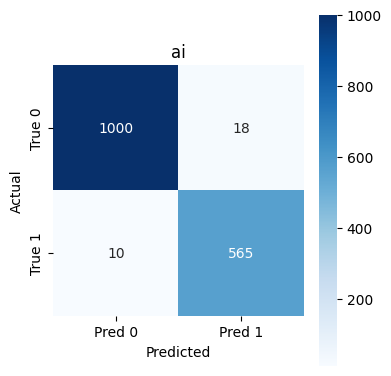

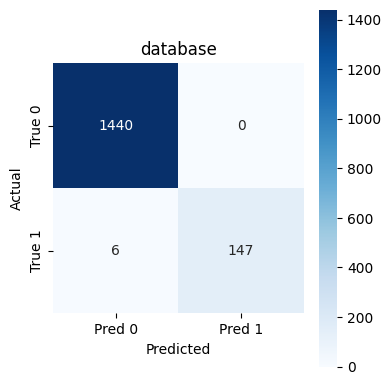

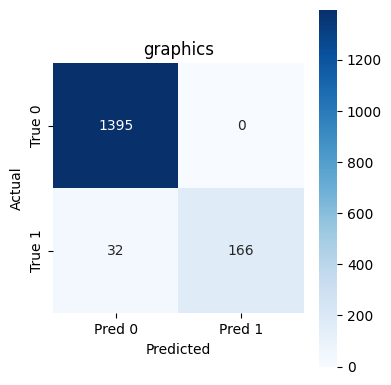

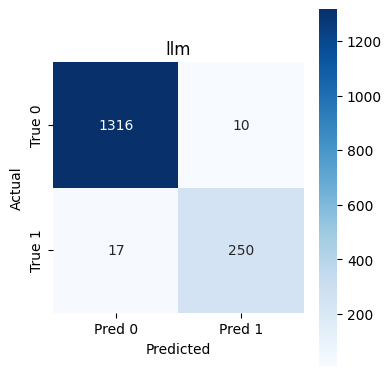

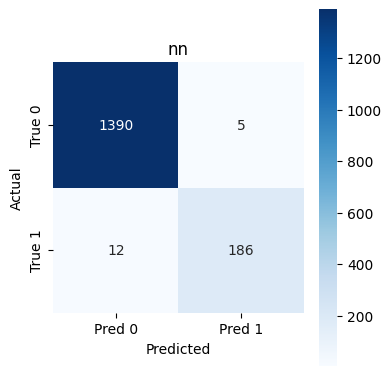

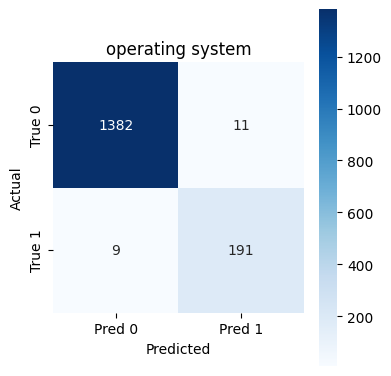

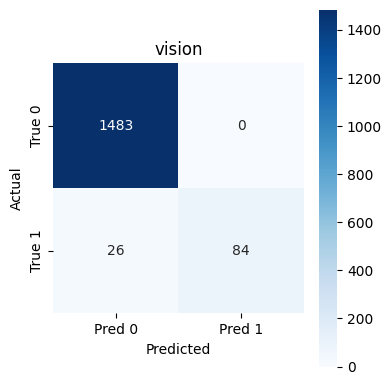

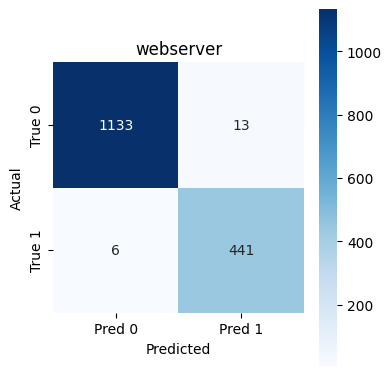

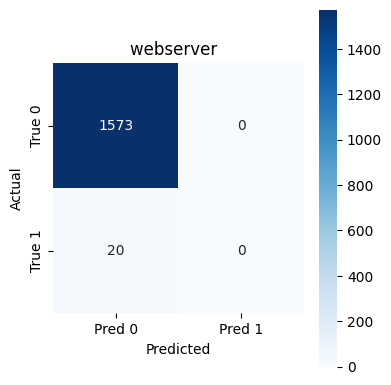

In [46]:
y_true_tensor = torch.stack(all_targets)
y_pred_tensor = torch.stack(all_preds)
y_true = y_true_tensor.numpy()
y_pred = y_pred_tensor.numpy()

num_classes = y_true.shape[1]

for i in range(num_classes):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plot_confusion(cm, class_name=mlb.classes_[i])

# Comparing Search Functions

In [47]:
import torch
from transformers import AutoModel
model = AutoModel.from_pretrained("microsoft/codebert-base")
def embed(tokens):
    with torch.no_grad():
        outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [50]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
def tokenize(code: str):
    return tokenizer(code, return_tensors="pt", padding=True)

In [52]:
def embed_query(query: str):
  return embed(tokenize(query))

In [53]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [59]:
vectors = list(collection.find())

In [97]:
projects_q = {
    "Project": ["llm.c", "nanoGPT", "convnetjs", "sql-server-samples", "tornado", "java-WebServer", "http_server", "polybar", "neuralnetworks", "libgd"],
    "Query": [
        "LLMs in simple, pure C/CUDA with no need for 245MB of PyTorch or 107MB of cPython. Current focus is on pretraining, in particular reproducing the GPT-2 and GPT-3 miniseries, along with a parallel PyTorch reference implementation in train_gpt2.py.",
        "The simplest, fastest repository for training/finetuning medium-sized GPTs. It is a rewrite of minGPT that prioritizes teeth over education. Still under active development, but currently the file train.py reproduces GPT-2 (124M) on OpenWebText",
        "ConvNetJS is a Javascript implementation of Neural networks, together with nice browser-based demos. It currently supports: Common Neural Network modules (fully connected layers, non-linearities) Classification (SVM/Softmax) and Regression (L2) cost functions.",
        "This GitHub repository contains code samples that demonstrate how to use Microsoft's Azure Data products including SQL Server, Azure SQL Database, Azure Synapse, and Azure SQL Edge. Each sample includes a README file that explains how to run and use the sample.",
        "Tornado is a Python web framework and asynchronous networking library, originally developed at FriendFeed. By using non-blocking network I/O, Tornado can scale to tens of thousands of open connections, making it ideal for long polling, WebSockets, and other applications that require a long-lived connection to each user.",
        "Java Web Server A simple multi-threaded HTTP 1.0 Server implemented in Java for educational purposes based on W3C specifications (http://www.w3.org/Protocols/)",
        "Simple Http Web Server in Linux using C/C++ from Scratch.",
        "Polybar aims to help users build beautiful and highly customizable status bars for their desktop environment, without the need of having a black belt in shell scripting.",
        "This is a Java implementation of some of the algorithms for training deep neural networks. GPU support is provided via the OpenCL and Aparapi. The architecture is designed with modularity, extensibility and pluggability in mind.",
        "GD is an open source code library for the dynamic creation of images by programmers."
    ]
}

In [98]:
queries = pd.DataFrame(projects_q)

In [99]:
def compute_cosine_sim(row):
  query_embedding = embed_query(row['Query']).reshape(1, -1)
  max_sim = 0
  for vector in vectors:
    sim = (cosine_similarity(query_embedding, np.array(vector['vector']).reshape(1, -1))[0][0])
    if sim > max_sim:
      max_sim = sim
      most_similar = vector
  return f"{most_similar['project_name']}: {max_sim}"

In [102]:
def compute_euclidean_sim(row):
  query_embedding = embed_query(row['Query']).reshape(1, -1)
  max_sim = 0
  for vector in vectors:
    sim = (euclidean_distances(query_embedding, np.array(vector['vector']).reshape(1, -1))[0][0])
    if sim > max_sim:
      max_sim = sim
      most_similar = vector
  return f"{most_similar['project_name']}: {max_sim}"

In [107]:
def compute_manhattan_dis(row):
  query_embedding = embed_query(row['Query']).reshape(1, -1)
  max_sim = 0
  for vector in vectors:
    sim = np.sum(np.abs(np.array(vector['vector']).reshape(1, -1) - query_embedding), axis=1)
    if sim > max_sim:
      max_sim = sim
      most_similar = vector
  return f"{most_similar['project_name']}: {max_sim}"

In [116]:
def compute_dot_product(row):
  query_embedding = embed_query(row['Query']).reshape(1, -1)
  max_sim = 0
  for vector in vectors:
    dot_prod = np.array(vector['vector']).reshape(1, -1) @ query_embedding.T
    dot_prod = dot_prod.flatten()
    if dot_prod > max_sim:
      max_sim = dot_prod
      most_similar = vector
  return f"{most_similar['project_name']}: {max_sim}"

In [100]:
queries['cosine'] = queries.apply(lambda row: compute_cosine_sim(row), axis=1)

In [103]:
queries['euclidean'] = queries.apply(lambda row: compute_euclidean_sim(row), axis=1)

In [108]:
queries['manhattan'] = queries.apply(lambda row: compute_manhattan_dis(row), axis=1)

In [117]:
queries['dot'] = queries.apply(lambda row: compute_dot_product(row), axis=1)

In [118]:
queries

,Project,Query,cosine,euclidean,manhattan,dot
0,llm.c,"LLMs in simple, pure C/CUDA with no need for 2...",neuralnetworks: 0.9883429409121752,libgd: 10.500104798865383,libgd: [227.60775165],polybar: [454.84362885]
1,nanoGPT,"The simplest, fastest repository for training/...",tornado: 0.9859600096233305,libgd: 10.407645203211109,libgd: [225.52433928],tornado: [453.05490446]
2,convnetjs,ConvNetJS is a Javascript implementation of Ne...,neuralnetworks: 0.9882573453165432,libgd: 10.489336463151837,libgd: [228.22582084],polybar: [459.07214562]
3,sql-server-samples,This GitHub repository contains code samples t...,sql-server-samples: 0.9800791918715347,libgd: 10.145330865907182,libgd: [219.00738529],tornado: [471.7957014]
4,tornado,Tornado is a Python web framework and asynchro...,neuralnetworks: 0.985949356667698,libgd: 10.750293183701865,libgd: [233.0290044],tornado: [454.70601438]
5,java-WebServer,Java Web Server A simple multi-threaded HTTP 1...,sql-server-samples: 0.9921125829552416,libgd: 10.680134712693201,libgd: [235.18066397],neuralnetworks: [451.08698155]
6,http_server,Simple Http Web Server in Linux using C/C++ fr...,sql-server-samples: 0.9945090138048399,libgd: 11.3314865898037,libgd: [250.5693416],neuralnetworks: [427.97312547]
7,polybar,Polybar aims to help users build beautiful and...,convnetjs: 0.9918564815184446,libgd: 11.1382107688894,libgd: [245.04351791],polybar: [427.35159333]
8,neuralnetworks,This is a Java implementation of some of the a...,neuralnetworks: 0.9875134785413661,libgd: 10.528854707031206,libgd: [229.97285182],neuralnetworks: [456.06968745]
9,libgd,GD is an open source code library for the dyna...,polybar: 0.9938211967130184,libgd: 11.279713666435967,libgd: [249.2747695],polybar: [425.98853269]
